In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sqlfunctions import get_datapunten_voor_model
import pickle

## Notities
Datapunten AI:
- omzet
- Beursgenoteerd of niet
- sector (nacebel code)
- aantal personeelsleden
- stedelijkheidsklasse
- site_aanwezig
- pdf_aanwezig

In [12]:
def get_initial_dataframe():
    data = get_datapunten_voor_model()
    dataframe = pd.DataFrame(data, columns=['ondernemingnr', 'omzet' ,'beursgenoteerd', 'sector', 'personeelsleden', 'site_aanwezig', 'pdf_aanwezig','stedelijkheidsklasse', 'score'])
    dataframe.drop("ondernemingnr", axis=1, inplace=True)
    return dataframe

def transform_data(data):
    data["sector"] = data["sector"].astype('category')
    data["beursgenoteerd"] = data["beursgenoteerd"].astype('category')
    data["pdf_aanwezig"] = data["pdf_aanwezig"].astype('category')
    data["site_aanwezig"] = data["site_aanwezig"].astype('category')
    data["stedelijkheidsklasse"] = data["stedelijkheidsklasse"].astype('category')

    min_max_scaler = MinMaxScaler()
    # data["omzet"] = min_max_scaler.fit_transform(data[["omzet"]])
    # pickle.dump(min_max_scaler, open("min_max_scaler_omzet.sav", "wb"))

    min_max_scaler = MinMaxScaler()
    # data["personeelsleden"] = min_max_scaler.fit_transform(data[["personeelsleden"]])
    # pickle.dump(min_max_scaler, open("min_max_scaler_personeelsleden.sav", "wb"))

    # fill omzet values that are 0 with the mean
    data["omzet"] = data["omzet"].replace(0, np.nan)
    data["omzet"] = data["omzet"].fillna(data["omzet"].mean())
    

    data["beursgenoteerd"] = data["beursgenoteerd"].cat.codes
    data["beursgenoteerd"] = data["beursgenoteerd"].astype('category')
    
    data["personeelsleden"] = data["personeelsleden"].astype('float')
    data["score"] = data["score"].astype('float')

    # getting rid of all values that are empty
    
    def to_float(x):
        if x == '':
            print(x)
            return np.nan
        else:
            return float(x)

    for col in data.columns:
        data[col] = data[col].apply(to_float)
    
    data = data.dropna()

    data["sector"] = data["sector"].astype('category')
    

    return data

In [14]:
dataframe = get_initial_dataframe()
dataframe = transform_data(dataframe)
print(dataframe.info())

print(dataframe.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 13471
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 13002 non-null  float64 
 1   beursgenoteerd        13002 non-null  category
 2   sector                13002 non-null  category
 3   personeelsleden       13002 non-null  float64 
 4   site_aanwezig         13002 non-null  category
 5   pdf_aanwezig          13002 non-null  category
 6   stedelijkheidsklasse  13002 non-null  category
 7   score                 13002 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 505.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 13471
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 13002 non-null  float64 
 1   beursgenoteerd        13002 non-null  cate

C:\Users\jarno\AppData\Local\Temp\ipykernel_32784\2967570457.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sector"] = data["sector"].astype('category')


In [15]:
df = dataframe[dataframe["omzet"] == 0]
# TODO:
# 1. Sector zorgen dat category blijft
# 2. degene met omzet 0 wegdoen

In [16]:
dataframe.head()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 13471
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 13002 non-null  float64 
 1   beursgenoteerd        13002 non-null  category
 2   sector                13002 non-null  category
 3   personeelsleden       13002 non-null  float64 
 4   site_aanwezig         13002 non-null  category
 5   pdf_aanwezig          13002 non-null  category
 6   stedelijkheidsklasse  13002 non-null  category
 7   score                 13002 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 505.0 KB


In [17]:
# get row with 131 employees
dataframe.loc[dataframe['personeelsleden'] == 131]

,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,stedelijkheidsklasse,score
322,47465600.0,0.0,41203.0,131.0,1.0,1.0,0.0,6.436944
580,35346386.0,0.0,46660.0,131.0,0.0,1.0,2.0,1.058113
1281,19626065.0,0.0,43211.0,131.0,1.0,1.0,1.0,4.438853
8092,24207188.0,0.0,49410.0,131.0,1.0,1.0,0.0,21.358442
10078,16577763.0,0.0,88994.0,131.0,1.0,1.0,2.0,1.040463


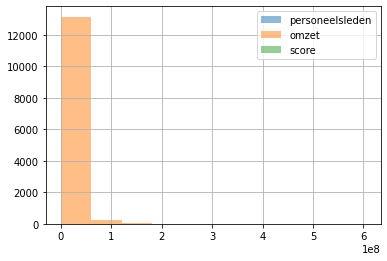

In [29]:
# Visualize data
# plot histogram
from matplotlib import pyplot as plt

dataframe["personeelsleden"].hist(label="personeelsleden", alpha=0.5)
dataframe["omzet"].hist(label="omzet", alpha=0.5)
dataframe["score"].hist(label="score", alpha=0.5)
plt.legend()



                    omzet  personeelsleden     score
omzet            1.000000         0.371883  0.134631
personeelsleden  0.371883         1.000000  0.090769
score            0.134631         0.090769  1.000000


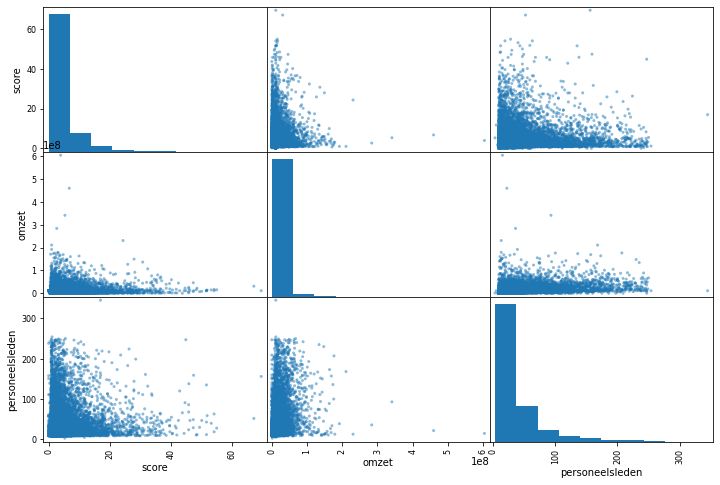

                    omzet  personeelsleden     score
omzet            1.000000         0.371883  0.134631
personeelsleden  0.371883         1.000000  0.090769
score            0.134631         0.090769  1.000000


In [37]:
# plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = dataframe.corr()
print(corr)
corr["score"].sort_values(ascending=False)
from pandas.plotting import scatter_matrix
attributes = ["score", "omzet", "personeelsleden", "beursgenoteerd"]
scatter_matrix(dataframe[attributes], figsize=(12, 8))
plt.show()


print(corr)



count    13002.000000
mean         4.328370
std          5.525646
min          0.000000
25%          1.048360
50%          2.427379
75%          5.047753
max         69.414583
Name: score, dtype: float64
Average score bedrijven with jaarrekening: 4.238338342672999
Average score bedrijven without jaarrekening: 6.4595743786660345
Average score bedrijven with site: 4.794731964571291
Average score bedrijven without site: 3.273116285536595
Average score bedrijven with both pdf and site: 4.691390156299451


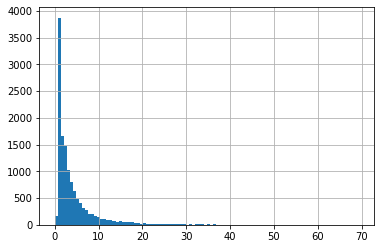

In [42]:
print(dataframe["score"].describe())
# plot a detailed histogram
dataframe["score"].hist(bins=100)

# print 10 most common scores
dataframe["score"].value_counts().head(10)

# print mean score
dataframe["score"].mean()

# where are 75% of the scores
dataframe["score"].quantile(0.75)

# average score of companies with that have pdf
print(f"Average score bedrijven with jaarrekening: {dataframe[dataframe['pdf_aanwezig'] == 1]['score'].mean()}")
print(f"Average score bedrijven without jaarrekening: {dataframe[dataframe['pdf_aanwezig'] == 0]['score'].mean()}")

# average score of companies with that have site
print(f"Average score bedrijven with site: {dataframe[dataframe['site_aanwezig'] == 1]['score'].mean()}")
print(f"Average score bedrijven without site: {dataframe[dataframe['site_aanwezig'] == 0]['score'].mean()}")

# average score of companies with that have both pdf and site
print(f"Average score bedrijven with both pdf and site: {dataframe[(dataframe['pdf_aanwezig'] == 1) & (dataframe['site_aanwezig'] == 1)]['score'].mean()}")

![white box ml modellen](https://drek4537l1klr.cloudfront.net/thampi/HighResolutionFigures/figure_2-2.png)


In [20]:
# Model schrijven
# ! Kan pas gerund worden vanaf we alle data hebben
# drop null values

X = dataframe.drop(columns=["score"])
y = dataframe["score"]

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.info()
y_test.info()

X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 9980 to 7700
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 11701 non-null  float64 
 1   beursgenoteerd        11701 non-null  category
 2   sector                11701 non-null  category
 3   personeelsleden       11701 non-null  float64 
 4   site_aanwezig         11701 non-null  category
 5   pdf_aanwezig          11701 non-null  category
 6   stedelijkheidsklasse  11701 non-null  category
dtypes: category(5), float64(2)
memory usage: 365.3 KB
<class 'pandas.core.series.Series'>
Int64Index: 1301 entries, 1126 to 4241
Series name: score
Non-Null Count  Dtype  
--------------  -----  
1301 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,stedelijkheidsklasse
9980,3.386902e+07,0.0,46319.0,49.0,1.0,1.0,0.0
4154,1.941809e+06,0.0,25999.0,9.0,0.0,1.0,0.0
8381,1.879906e+06,0.0,43310.0,12.0,1.0,1.0,0.0
11848,1.114040e+07,0.0,49410.0,34.0,1.0,0.0,1.0
13047,1.376458e+06,0.0,1610.0,14.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
12428,7.628510e+05,0.0,43130.0,17.0,1.0,1.0,0.0
5515,1.463745e+06,0.0,17120.0,22.0,1.0,1.0,1.0
5723,2.417031e+06,0.0,52290.0,16.0,1.0,1.0,2.0
897,1.154600e+07,0.0,11050.0,35.0,1.0,1.0,1.0


In [47]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
print("------------- Linear Regression --------------")

lin_reg = LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
# lin_reg = GridSearchCV(lin_reg, parameters, scoring="neg_mean_squared_error", cv=5)
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
# print(f"Best parameters: {lin_reg.best_params_}")
# print(f"Best score: {lin_reg.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lin_reg)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))}")

# Linear Regression with model that uses only omzet and personeelsleden
print("------------- Linear Regression with omzet and personeelsleden --------------")
lin_reg_omzet_personeelsleden = LinearRegression()
lin_reg_omzet_personeelsleden.fit(X_train[["omzet", "personeelsleden"]], y_train)
y_pred_lin_reg_omzet_personeelsleden = lin_reg_omzet_personeelsleden.predict(X_test[["omzet", "personeelsleden"]])
print(f"MSE: {mean_squared_error(y_test, y_pred_lin_reg_omzet_personeelsleden)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin_reg_omzet_personeelsleden))}")



------------- Linear Regression --------------
MSE: 25.510943052058995
RMSE: 5.050835876571223
------------- Linear Regression with omzet and personeelsleden --------------
MSE: 25.783303527953937
RMSE: 5.077726216324974
------------- Linear Regression with polynomial features --------------
MSE: 35.68510294645542
RMSE: 5.973700942167713


In [51]:


# SVR (Support Vector Regression)
from sklearn.svm import SVR
print("------------- SVR --------------")
svr_regressor = SVR(kernel='rbf', gamma="scale")
parameters = {'C': [1, 10, 20], 'epsilon': [0.1, 0.01, 0.001, 0.0001]}
svr_regressor = GridSearchCV(svr_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)
print(f"Best parameters: {svr_regressor.best_params_}")
print(f"Best score: {svr_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")



# BayesianRidge
from sklearn.linear_model import BayesianRidge
print("------------- BayesianRidge --------------")
bayesian_regressor = BayesianRidge()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
bayesian_regressor = GridSearchCV(bayesian_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
bayesian_regressor.fit(X_train, y_train)
y_pred_bay = bayesian_regressor.predict(X_test)
print(f"Best parameters: {bayesian_regressor.best_params_}")
print(f"Best score: {bayesian_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_bay)}")



------------- SVR --------------


KeyboardInterrupt: 

In [78]:

# LassoLars
from sklearn.linear_model import LassoLars
print("------------- LassoLars --------------")
lassolars_regressor = LassoLars()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lassolars_regressor = GridSearchCV(lassolars_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
lassolars_regressor.fit(X_train, y_train)
y_pred_lassolars = lassolars_regressor.predict(X_test)
print(f"Best parameters: {lassolars_regressor.best_params_}")
print(f"Best score: {lassolars_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lassolars)}")

------------- LassoLars --------------
Best parameters: {'alpha': 0.1}
Best score: -66.73229523206487
MSE: 69.26397168897147


In [20]:
# ARDRegression
from sklearn.linear_model import ARDRegression
print("------------- ARDRegression --------------")
ard_regressor = ARDRegression()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
ard_regressor = GridSearchCV(ard_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ard_regressor.fit(X_train, y_train)
y_pred_ard = ard_regressor.predict(X_test)
print(f"Best parameters: {ard_regressor.best_params_}")
print(f"Best score: {ard_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ard)}")
print("------------- ARDRegression --------------")f


------------- ARDRegression --------------
Best parameters: {'alpha_1': 100, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 100}
Best score: -239.77754245903506
MSE: 257.4716380613389


In [18]:

# PassiveAggressiveRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
print("------------- PassiveAggressiveRegressor --------------")
passive_regressor = PassiveAggressiveRegressor()
parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'epsilon': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
passive_regressor = GridSearchCV(passive_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
passive_regressor.fit(X_train, y_train)
y_pred_pas = passive_regressor.predict(X_test)
print(f"Best parameters: {passive_regressor.best_params_}")
print(f"Best score: {passive_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_pas)}")


------------- PassiveAggressiveRegressor --------------
Best parameters: {'C': 0.1, 'epsilon': 1}
Best score: -0.0015840646966771455
MSE: 0.0014411840660125688


In [28]:

# TheilSenRegressor
from sklearn.linear_model import TheilSenRegressor
print("------------- TheilSenRegressor --------------")
theil_regressor = TheilSenRegressor()
parameters = {'max_subpopulation': [100, 500, 1000, 5000]}
theil_regressor = GridSearchCV(theil_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
theil_regressor.fit(X_train, y_train)
y_pred_seil = theil_regressor.predict(X_test)
print(f"Best parameters: {theil_regressor.best_params_}")
print(f"Best score: {theil_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_seil)}")



------------- TheilSenRegressor --------------
Best parameters: {'max_subpopulation': 1000}
Best score: -248.86399538690165
MSE: 271.1236378199631


In [33]:
# RANSACRegressor
from sklearn.linear_model import RANSACRegressor
print("------------- RANSACRegressor --------------")
ransac_regressor = RANSACRegressor()
parameters = {'min_samples': [1, 5, 10, 50, 100, 500, 1000], 'max_trials': [100, 500, 1000, 5000]}
ransac_regressor = GridSearchCV(ransac_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ransac_regressor.fit(X_train, y_train)
y_pred_ransac = ransac_regressor.predict(X_test)
print(f"Best parameters: {ransac_regressor.best_params_}")
print(f"Best score: {ransac_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ransac)}")

------------- RANSACRegressor --------------
Best parameters: {'max_trials': 500, 'min_samples': 1000}
Best score: -246.0978794101151
MSE: 263.4648095046217


In [32]:
# ridge regression
from sklearn.linear_model import Ridge
print("------------- Ridge regression --------------")
ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
print(f"Best parameters: {ridge_regressor.best_params_}")
print(f"Best score: {ridge_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")

# Lasso regression
from sklearn.linear_model import Lasso
print("------------- Lasso regression --------------")
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error", cv=5)
lasso_regressor.fit(X_train, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
y_pred_lasso = lasso_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")


------------- Ridge regression --------------
Best parameters: {'alpha': 0.5}
Best score: -239.77330520826112
MSE: 257.4407573953995
------------- Lasso regression --------------
{'alpha': 0.1}
-243.35376774547677
MSE: 261.7385916220957


In [54]:
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11709 entries, 6257 to 7693
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 11709 non-null  float64 
 1   beursgenoteerd        11709 non-null  category
 2   sector                11709 non-null  category
 3   personeelsleden       11709 non-null  float64 
 4   site_aanwezig         11709 non-null  category
 5   pdf_aanwezig          11709 non-null  category
 6   stedelijkheidsklasse  11709 non-null  category
dtypes: category(5), float64(2)
memory usage: 365.5 KB
<class 'pandas.core.series.Series'>
Int64Index: 11709 entries, 6257 to 7693
Series name: score
Non-Null Count  Dtype  
--------------  -----  
11709 non-null  float64
dtypes: float64(1)
memory usage: 183.0 KB


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Random forest regression
from sklearn.ensemble import RandomForestRegressor
print("------------- Random forest regression --------------")
random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=5)
# parameters = {'n_estimators': [50, 100, 200, 500, 1000], 'max_depth': [2, 3, 5, 10, 15, 20, 30]}

# random_forest_regressor = GridSearchCV(random_forest_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
random_forest_regressor.fit(X_train, y_train)
# print(random_forest_regressor.best_params_)
# print(random_forest_regressor.best_score_)
y_pred_random = random_forest_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_random)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_random)}")

filename = 'final_model.sav'
pickle.dump(random_forest_regressor, open(f'ml_files\\{filename}', 'wb'))




------------- Random forest regression --------------
MSE: 25.23357529423757
MAE: 3.3185558628583043
------------- Random forest regression with only omzet and personeelsleden --------------
MSE: 25.658382128203
MAE: 3.3500758243635795


In [96]:
# get all the predictions
y_pred_random

array([3.51191143, 2.60878313, 4.93913229, ..., 3.56892299, 3.44716493,
       6.48788698])

In [24]:
y_test.describe()

count    1301.000000
mean       12.988336
std        16.939520
min         0.000000
25%         3.168856
50%         7.643152
75%        14.766377
max       162.098438
Name: score, dtype: float64

In [33]:
# R2 scores berekenen voor elk model
from sklearn.metrics import r2_score
print("------------- R2 scores --------------")
print(f"R2 score linear regression: {r2_score(y_test, y_pred_lin_reg)}")
# print(f"R2 score ridge regression: {r2_score(y_test, y_pred_ridge)}")
# print(f"R2 score lasso regression: {r2_score(y_test, y_pred_lasso)}")
# print(f"R2 score passive aggressive regression: {r2_score(y_test, y_pred_pas)}")
# print(f"R2 score theil sen regression: {r2_score(y_test, y_pred_seil)}")
# print(f"R2 score ransac regression: {r2_score(y_test, y_pred_ransac)}")
print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


------------- R2 scores --------------
R2 score linear regression: 0.03136486267104133
R2 score random forest regression: 0.044529532261978644


In [34]:
from sklearn.metrics import r2_score

# print random forest feature importance
importances = random_forest_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_regressor.estimators_],
                axis=0) 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(f"-> {X_train.columns[indices[f]]}")


print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


Feature ranking:
1. feature 0 (0.617761)
-> omzet
2. feature 2 (0.153401)
-> sector
3. feature 3 (0.116494)
-> personeelsleden
4. feature 4 (0.083296)
-> site_aanwezig
5. feature 5 (0.016572)
-> pdf_aanwezig
6. feature 6 (0.012477)
-> stedelijkheidsklasse
7. feature 1 (0.000000)
-> beursgenoteerd
R2 score random forest regression: 0.044529532261978644


In [36]:
# get score if model predicted the mean of the training set score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print("------------- Mean score --------------")
mean_score = np.mean(y_train)
print(f"Mean score: {mean_score}")
y_pred_mean = np.full(y_test.shape, mean_score)
print(f"MSE: {mean_squared_error(y_test, y_pred_mean)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_mean)}")
print(f"R2 score: {r2_score(y_test, y_pred_mean)}")

# Model that always predicts 2.4
print("------------- Model that always predicts 2.4 --------------")
y_pred_24 = np.full(y_test.shape, 2.4)
print(f"MSE: {mean_squared_error(y_test, y_pred_24)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_24)}")
print(f"R2 score: {r2_score(y_test, y_pred_24)}")



------------- Mean score --------------
Mean score: 4.340327623743811
MSE: 26.351280359443056
MAE: 3.4521001327028116
R2 score: -0.0005422385866249435
------------- Model that always predicts 2.4 --------------
MSE: 33.73988673071171
MAE: 3.089420910825263
R2 score: -0.28108317086414814


In [ ]:
# saving the best model
import pickle
filename = 'final_model.sav'
pickle.dump(random_forest_regressor, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

# make a prediction
new_data = X_test.iloc[0]
print([new_data])
print(loaded_model.predict([new_data]))
new_data = [0.00438, 0, 375.0, 0, 0, 1]
print(loaded_model.predict([new_data]))
# shape to 2d array (1, 6)
# loaded_model.predict(np.shape([[0.00438, False, 375.0, 0, 0, 1]], -1))


In [ ]:
# visualise how randomforestregressor works
from sklearn.tree import export_graphviz
import pydot
tree = random_forest_regressor.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_train.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
